In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import pickle

In [2]:
import torch
from skimage import io
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, ChebConv,GATv2Conv, SAGEConv,global_max_pool, global_mean_pool
import numpy as np


import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

# from modeling import build_unet
# from modeling import DiceLoss, DiceBCELoss
import random
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch_geometric.nn import knn_graph
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import cv2
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

In [3]:
def list_folders(path):
    try:
        # Get a list of all entries in the directory
        entries = os.listdir(path)

        # Filter out only directories
        subfolders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]

        return subfolders

    except OSError as e:
        print(f"Error reading the directory: {e}")
        return []

In [4]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
def get_only(images,selection="B"):
    
    
    image1_indx = int(images[0].split(".")[0].split("_")[-1])
    image2_indx = int(images[1].split(".")[0].split("_")[-1])
        
    if selection == "L": 
        
        if image2_indx > image1_indx:
            return [images[0]]
        else:
            return [images[1]]
        
    elif selection == "R":
        
        if image2_indx > image1_indx:
            return [images[1]]
        else:
            return [images[0]]
        
    elif selection== "B":
        if image2_indx > image1_indx:
            return [images[0], images[1]]
        else:
            return [images[1], images[0]]
        
        
        
    return []

In [7]:
base_dir = "C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\"
types = ["Diabetes","Control"]

X = []
y = []
paths = []
diabetes_df = pd.read_excel(base_dir+"Diabetic_Iris.xlsx")
control_df = pd.read_excel(base_dir+"Control_Iris.xlsx")

CURRENT_FILTER = "B"

for t in types:
    
    label = 1 if t == "Diabetes" else 0
    
    navigating_df = diabetes_df if t=="Diabetes" else control_df
    
    path = base_dir+t
    sub_folders = list_folders(path)
    
    
    for sub in sub_folders:
        if "-" in sub:
            continue
            
        filtered_row = navigating_df[navigating_df["ID"]==int(sub)]
        img_dir = path + "\\" + sub
        jpg_files = glob(os.path.join(img_dir, '*.jpg'))
#         print(t,sub,jpg_files)
        
        if filtered_row["Eye"].iloc[0] == CURRENT_FILTER:
            pass
        elif filtered_row["Eye"].iloc[0] == "B":
            jpg_files = get_only(jpg_files,CURRENT_FILTER)
        else:
            continue
            
        both_eyes = []
        
        
        for indx,img_file in enumerate(jpg_files):
            
            x = cv2.imread(img_file, cv2.IMREAD_COLOR)
            x = cv2.resize(x,(1600,1066))
            
#             print(img_file)
#             plt.imshow(x)
#             plt.show()
            
            x = x[40:,200:,:]
            x = x[:-40,:-200,:]
        
            
#             aug = HorizontalFlip(p=1.0)
#             augmented = aug(image=x)
#             x1 = augmented["image"]

#             aug = VerticalFlip(p=1.0)
#             augmented = aug(image=x)
#             x2 = augmented["image"]

#             aug = Rotate(limit=30, p=1.0,interpolation=cv2.INTER_NEAREST)
#             augmented = aug(image=x)
#             x3 = augmented["image"]
            
            if CURRENT_FILTER != "B":
                X.append(x)
                y.append(label)
                paths.append(img_file)
            else:
                both_eyes.append(x)
                paths.append(img_file)
            
    
    
        if CURRENT_FILTER == "B":
            X.append(both_eyes)
            y.append(label)
            
pos = None
if CURRENT_FILTER == "R":
    pos = "right"
elif CURRENT_FILTER == "L":
    pos = "left"
elif CURRENT_FILTER == "B":
    pos = "both"
    
test_image_files = glob(f"C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\final_test_dataset\\{pos}\\*.jpg")
selections = ["left","right"]
for i in range(1,89):
    
    
    both_eyes = []
    
    for selection in selections:
        
        for img_file in test_image_files:
            
            if f"test_{i}_{selection}" in img_file:
    
                x = cv2.imread(img_file, cv2.IMREAD_COLOR)
                x = cv2.resize(x,(1600,1066))

                x = x[40:,200:,:]
                x = x[:-40,:-200,:]

                label = int(img_file.split("\\")[-1].split(".")[0].split("_")[-1])
                if CURRENT_FILTER != "B":
                    X.append(x)
                    y.append(label)
                    paths.append(img_file)
                else:
                    both_eyes.append(x)
                    paths.append(img_file)
                    
    if len(both_eyes) == 2:
        X.append(both_eyes)
        y.append(label)
    

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True,stratify=y)


create_dir("Iridology_dataset/train")
create_dir("Iridology_dataset/test")



train_file_base = "Iridology_dataset/train/train_"
test_file_base = "Iridology_dataset/test/test_"

j = 0
for i in range(len(X_train)):

    for pos in range(2):
        eye_type = "left" if pos == 0 else "right"
        path = train_file_base +   f"{j}_{eye_type}_{y_train[i]}.jpg"
        cv2.imwrite(path,X_train[i][pos])

        path1 = train_file_base +   f"{j+1}_{eye_type}_{y_train[i]}.jpg"
        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=X_train[i][pos])
        x1 = augmented["image"]
        cv2.imwrite(path1,x1)

        path2 = train_file_base +   f"{j+2}_{eye_type}_{y_train[i]}.jpg"
        aug = VerticalFlip(p=1.0)
        augmented = aug(image=X_train[i][pos])
        x2 = augmented["image"]
        cv2.imwrite(path2,x2)

        path3 = train_file_base +   f"{j+3}_{eye_type}_{y_train[i]}.jpg"
        aug = Rotate(limit=30, p=1.0,interpolation=cv2.INTER_NEAREST)
        augmented = aug(image=X_train[i][pos])
        x3 = augmented["image"]
        cv2.imwrite(path3,x3)

    j += 4
    

for i in range(len(X_val)):
    
    for pos in range(2):
        eye_type = "left" if pos == 0 else "right"
        
        path = test_file_base +  f"{i}_{eye_type}_{y_val[i]}.jpg"
        cv2.imwrite(path,X_val[i][pos])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True,stratify=y)


create_dir("Iridology_dataset/train")
create_dir("Iridology_dataset/test")



train_file_base = "Iridology_dataset/train/train_"
test_file_base = "Iridology_dataset/test/test_"

j = 0
for i in range(len(X_train)):
    path = train_file_base +   f"{j}_{y_train[i]}.jpg"
    cv2.imwrite(path,X_train[i])
    
    path1 = train_file_base +   f"{j+1}_{y_train[i]}.jpg"
    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=X_train[i])
    x1 = augmented["image"]
    cv2.imwrite(path1,x1)
    
    path2 = train_file_base +   f"{j+2}_{y_train[i]}.jpg"
    aug = VerticalFlip(p=1.0)
    augmented = aug(image=X_train[i])
    x2 = augmented["image"]
    cv2.imwrite(path2,x2)
    
    path3 = train_file_base +   f"{j+3}_{y_train[i]}.jpg"
    aug = Rotate(limit=30, p=1.0,interpolation=cv2.INTER_NEAREST)
    augmented = aug(image=X_train[i])
    x3 = augmented["image"]
    cv2.imwrite(path3,x3)
    
    j += 4
    

for i in range(len(X_val)):
    path = test_file_base +  f"{i}_{y_val[i]}.jpg"
    cv2.imwrite(path,X_val[i])
    

In [6]:
train_file_base = "Iridology_dataset\\Left Eye Total Results\\train\\"
test_file_base = "Iridology_dataset\\Left Eye Total Results\\test\\"

train_paths = glob(train_file_base + '*.jpg')
test_paths = glob(test_file_base + '*.jpg')

In [6]:
train_file_base = "C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\Both_Eyes_Total\\train\\"
test_file_base = "C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\Both_Eyes_Total\\test\\"

train_all_paths = glob(train_file_base + '*.jpg')
test_all_paths = glob(test_file_base + '*.jpg')


train_paths = []
test_paths = []


for i in range(len(train_all_paths)//2):
    
    search_identifier = f"train_{i}_"
    
    both_eyes = [None,None]
    for path in train_all_paths:
        
        left_identifier = search_identifier + "left"
        right_identifier = search_identifier + "right"
        
        if left_identifier  in path:
            both_eyes[1] = path
        elif right_identifier in path:
            both_eyes[0] = path
            
    
    train_paths.append(both_eyes)
    
    

for i in range(1,89):
    
    search_identifier = f"test_{i}_"
    
    both_eyes = [None,None]
    for path in test_all_paths:
        
        left_identifier = search_identifier + "left"
        right_identifier = search_identifier + "right"
        
        if left_identifier  in path:
            both_eyes[1] = path
        elif right_identifier in path:
            both_eyes[0] = path
            
    if both_eyes[0] != None and both_eyes[1] != None:
        test_paths.append(both_eyes)

# Modeling

In [23]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c,k_size):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=k_size, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=k_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [24]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c,k_size):
        super().__init__()

        self.conv = conv_block(in_c, out_c,k_size)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [130]:
class GCNBottleneck(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn1 = SAGEConv(in_channels, hidden_channels)
        self.gcn2 = SAGEConv(hidden_channels, 128)


    def forward(self, p4):
        batch_size, num_channels, height, width = p4.size()

        # Reshape p4 to form node features for the graph
        x = p4.view(batch_size, num_channels, -1).permute(0, 2, 1)  # [batch_size, height*width, num_channels]
        # Create k-nearest neighbor graph
        graphs = []
        
        for g in x:
            edge_index = knn_graph(g, k=8, loop=False)

            # Pass the node features through the GCN layer
            out = self.gcn1(g, edge_index)
            out = F.relu(out)
            out = self.gcn2(out, edge_index)
            
            # Reshape back to the original shape

            graphs.append(out)
            
        graphs = torch.stack(graphs, dim=0)
        return graphs

In [131]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(6, 32,7)
        self.e2 = encoder_block(32, 64,5)
        self.e3 = encoder_block(64, 128,5)
        self.e4 = encoder_block(128, 256,3)
        self.e5 = encoder_block(256, 512,3)
        
        
        """ Bottleneck """
#         self.b = conv_block(512, 1024)
        self.gcn_bottleneck = GCNBottleneck(512, 256)


        """ Classifier """
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.outputs = nn.Linear(64, 1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        s5, p5 = self.e5(p4)
        

        """ Bottleneck """
#         b = self.b(p4)
#         print("P4: ",p4.shape)
        gcn_output = self.gcn_bottleneck(p5)
#         print("GCN OUTPUT",gcn_output.shape)
        node_size = gcn_output.shape[1]
        batch_tensor = torch.zeros(node_size,dtype=torch.int64)
        batch_tensor = batch_tensor.to(inputs.device)
        
        pooled = []
        for g in gcn_output:
            pooled_output = global_mean_pool(g,batch_tensor)
            pooled.append(pooled_output)
            
        pooled = torch.stack(pooled, dim=0).reshape(-1,128)
#         print("pooled",pooled.shape)
        outputs = self.fc1(pooled)
        outputs = self.dropout(outputs)
#         print("FC1 ",outputs.shape)
        outputs = F.relu(outputs)
        outputs = self.outputs(outputs)
    

        return outputs

In [133]:
class simpleModel(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super(simpleModel, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=7, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64*122*149, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*122*149)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [90]:
class IrisDataset(Dataset):
    def __init__(self, images_path):

        self.images = images_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        path = self.images[index]
        label = int(path.split("/")[-1].split(".")[0].split("_")[-1])
        
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = image/255.0 ## 
        image = np.transpose(image, (2, 0, 1))  ## 
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
       

        return image, label

    def __len__(self):
        return self.n_samples

In [134]:
# class IrisDataset(Dataset):
#     def __init__(self, images_path):

#         self.images = images_path
#         self.n_samples = len(images_path)

#     def __getitem__(self, index):
#         """ Reading image """
#         paths = self.images[index]
        
#         both_eyes = []
        
#         for path in paths:
#             label = int(path.split("/")[-1].split(".")[0].split("_")[-1])

#             image = cv2.imread(path, cv2.IMREAD_COLOR)
#             image = image/255.0 ##  
#             image = image.astype(np.float32)
#             image = torch.from_numpy(image)
            
#             both_eyes.append(image)
            
#         image = np.concatenate(both_eyes, axis=2)
#         image = np.transpose(image, (2, 0, 1))  ##
#         """ Reading mask """
       

#         return image, label

#     def __len__(self):
#         return self.n_samples

In [135]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [136]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [137]:
def threshold_predictions(predictions, threshold=0.5):
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    return predictions

In [138]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32).view(-1,1)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred,y)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        y_pred_thresholded = threshold_predictions(torch.sigmoid(y_pred.clone()))
        
        y_pred_np = y_pred_thresholded.cpu().detach().numpy().flatten()
        y_np = y.cpu().numpy().flatten()

        true_positives += np.sum((y_pred_np == 1) & (y_np == 1))
        false_positives += np.sum((y_pred_np == 1) & (y_np == 0))
        false_negatives += np.sum((y_pred_np == 0) & (y_np == 1))
        
        correct_predictions += torch.sum(y_pred_thresholded == y).item()
        total_samples += y.numel()


    epoch_loss = epoch_loss / len(loader)
    accuracy = correct_predictions / total_samples
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    
    return epoch_loss, accuracy,precision,recall

In [62]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32).view(-1,1)

            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            epoch_loss += loss.item()
            
            # Threshold predictions and calculate accuracy
            y_pred_thresholded = threshold_predictions(torch.sigmoid(y_pred.clone()))
            
            y_pred_np = y_pred_thresholded.cpu().detach().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            true_positives += np.sum((y_pred_np == 1) & (y_np == 1))
            false_positives += np.sum((y_pred_np == 1) & (y_np == 0))
            false_negatives += np.sum((y_pred_np == 0) & (y_np == 1))
            correct_predictions += torch.sum(y_pred_thresholded == y).item()
            total_samples += y.numel()

        epoch_loss = epoch_loss / len(loader)
        accuracy = correct_predictions / total_samples
        
        precision = true_positives / (true_positives + false_positives + 1e-10)
        recall = true_positives / (true_positives + false_negatives + 1e-10)
    
    return (epoch_loss, accuracy,precision,recall) , (true_positives,false_positives,false_negatives)

In [63]:
def log_to_tensorboard(writer, phase,trial, epoch, loss, accuracy, precision, recall):
    writer.add_scalars(f'{phase}/Loss', {f"trial_{trial}":loss}, epoch)
    writer.add_scalars(f'{phase}/Accuracy', {f"trial_{trial}":accuracy}, epoch)
    writer.add_scalars(f'{phase}/Precision', {f"trial_{trial}":precision}, epoch)
    writer.add_scalars(f'{phase}/Recall', {f"trial_{trial}":recall}, epoch)

In [19]:
seeding(42)

""" Directories """
create_dir("files_cnn_left")
create_dir("files_cnn_left/checkpoints")
create_dir("files_cnn_left/saved_metrics")
create_dir("files_cnn_left/saved_metrics/train")
create_dir("files_cnn_left/saved_metrics/val")

""" Load dataset """
data_str = f"Dataset Size:\nTrain: {len(train_paths)} - Valid: {len(test_paths)}\n"
print(data_str)

batch_size = 16
num_epochs = 50
lr = 1e-5
checkpoint_path = "files_cnn_left/checkpoints/"

""" Dataset and loader """

train_dataset = IrisDataset(train_paths)
valid_dataset = IrisDataset(test_paths)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_writer = SummaryWriter(log_dir=f'files_cnn_left/tensorboard/train')
valid_writer = SummaryWriter(log_dir=f'files_cnn_left/tensorboard/valid')


for trial in range(1):
    print(f"Starting Trial {trial + 1}")
#     model = build_unet().to(device)
    model = simpleModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = nn.BCEWithLogitsLoss()

    best_valid_loss = float("inf")


    train_metrics = []
    val_metrics = []

    for epoch in range(num_epochs):
        start_time = time.time()

        metric = train(model, train_loader, optimizer, loss_fn, device)
        train_metrics.append(metric)
        train_loss, train_acc, train_prec, train_rec = metric
        val_metric, seperate = evaluate(model, valid_loader, loss_fn, device)
        val_metrics.append(val_metric)

        valid_loss, val_acc, val_prec, val_rec = val_metric

        # Log metrics to TensorBoard
        log_to_tensorboard(train_writer, f'train', trial, epoch, train_loss, train_acc, train_prec, train_rec)
        log_to_tensorboard(valid_writer, f'valid', trial, epoch, valid_loss, val_acc, val_prec, val_rec)

        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: { checkpoint_path+f'checkpoint_{trial}.pth'}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path+f"checkpoint_{trial}.pth")

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}  | Train Accuracy: {train_acc:.4f} | Train Precision: {train_prec:.4f} | Train Recall: {train_rec:.4f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}  | Val. Accuracy: {val_acc:.4f}    | Val. Precision: {val_prec:.4f} | Val. Recall: {val_rec:.4f}\n'
        print(data_str)
        
    with open(f'files_cnn_left/saved_metrics/train/{trial}.pkl', 'wb') as train_file:
        pickle.dump(train_metrics, train_file)
        
    with open(f'files_cnn_left/saved_metrics/val/{trial}.pkl', 'wb') as val_file:
        pickle.dump(val_metrics, val_file)

Dataset Size:
Train: 756 - Valid: 48

Starting Trial 1
Valid loss improved from inf to 0.6828. Saving checkpoint: files_cnn_left/checkpoints/checkpoint_0.pth
Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 0.707  | Train Accuracy: 0.5635 | Train Precision: 0.5172 | Train Recall: 0.4412
	 Val. Loss: 0.683  | Val. Accuracy: 0.5833    | Val. Precision: 0.5217 | Val. Recall: 0.5714

Valid loss improved from 0.6828 to 0.6732. Saving checkpoint: files_cnn_left/checkpoints/checkpoint_0.pth
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 0.658  | Train Accuracy: 0.6085 | Train Precision: 0.5846 | Train Recall: 0.4471
	 Val. Loss: 0.673  | Val. Accuracy: 0.6042    | Val. Precision: 0.5455 | Val. Recall: 0.5714

Valid loss improved from 0.6732 to 0.6725. Saving checkpoint: files_cnn_left/checkpoints/checkpoint_0.pth
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.650  | Train Accuracy: 0.6177 | Train Precision: 0.5914 | Train Recall: 0.4853
	 Val. Loss: 0.673  | Val. Accuracy: 0.6042    | Val. Precision: 

Epoch: 33 | Epoch Time: 0m 32s
	Train Loss: 0.406  | Train Accuracy: 0.8161 | Train Precision: 0.7738 | Train Recall: 0.8353
	 Val. Loss: 0.688  | Val. Accuracy: 0.5625    | Val. Precision: 0.5000 | Val. Recall: 0.2381

Epoch: 34 | Epoch Time: 0m 31s
	Train Loss: 0.401  | Train Accuracy: 0.8307 | Train Precision: 0.8118 | Train Recall: 0.8118
	 Val. Loss: 0.670  | Val. Accuracy: 0.5833    | Val. Precision: 0.5333 | Val. Recall: 0.3810

Epoch: 35 | Epoch Time: 0m 32s
	Train Loss: 0.385  | Train Accuracy: 0.8267 | Train Precision: 0.8065 | Train Recall: 0.8088
	 Val. Loss: 0.653  | Val. Accuracy: 0.6042    | Val. Precision: 0.5714 | Val. Recall: 0.3810

Epoch: 36 | Epoch Time: 0m 31s
	Train Loss: 0.397  | Train Accuracy: 0.8399 | Train Precision: 0.8192 | Train Recall: 0.8265
	 Val. Loss: 0.644  | Val. Accuracy: 0.6458    | Val. Precision: 0.6429 | Val. Recall: 0.4286

Epoch: 37 | Epoch Time: 0m 31s
	Train Loss: 0.376  | Train Accuracy: 0.8439 | Train Precision: 0.8153 | Train Recall: 0.

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = build_unet()
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# """ Training the model """
# best_valid_loss = float("inf")

# train_metrics = []
# val_metrics = []



# for epoch in range(num_epochs):
#     start_time = time.time()
    
#     metric = train(model, train_loader, optimizer, loss_fn, device)
#     train_metrics.append(metric)
#     train_loss, train_acc,train_prec,train_rec = metric
#     val_metric = evaluate(model, valid_loader, loss_fn, device)
#     val_metrics.append(val_metric)
    
#     valid_loss, val_acc,val_prec,val_rec = val_metric

#     """ Saving the model """
#     if valid_loss < best_valid_loss:
#         data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
#         print(data_str)

#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), checkpoint_path)

#     end_time = time.time()
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
#     data_str += f'\tTrain Loss: {train_loss:.3f}  | Train Accuracy: {train_acc:.4f} | Train Precision: {train_prec:.4f} | Train Recall: {train_rec:.4f}\n'
#     data_str += f'\t Val. Loss: {valid_loss:.3f}  | Val. Accuracy: {val_acc:.4f}    | Val. Precision: {val_prec:.4f} | Val. Recall: {val_rec:.4f}\n'
#     print(data_str)

In [21]:
train_loss = []
train_accuracy = []
train_precision = []
train_recall = []

val_loss = []
val_accuracy = []
val_precision = []
val_recall = []


epochs = [i+1 for i in range(len(train_metrics))]



for i in range(len(train_metrics)):
    
    train_loss.append(train_metrics[i][0])
    train_accuracy.append(train_metrics[i][1])
    train_precision.append(train_metrics[i][2])
    train_recall.append(train_metrics[i][3])
    
    
    val_loss.append(val_metrics[i][0])
    val_accuracy.append(val_metrics[i][1])
    val_precision.append(val_metrics[i][2])
    val_recall.append(val_metrics[i][3])

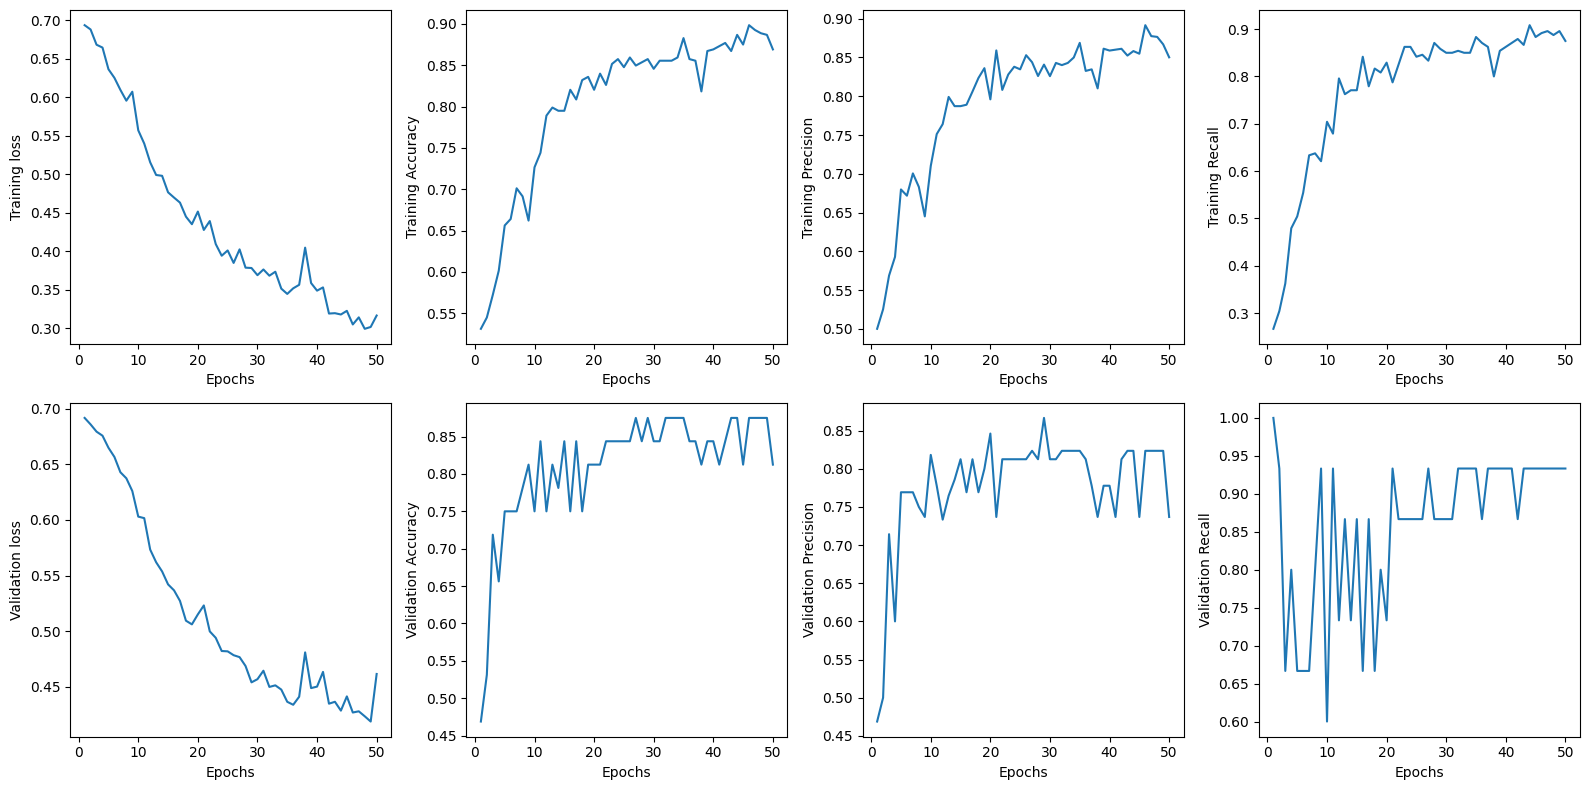

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

# Example: Plotting something on each subplot

axs[0,0].plot(epochs,train_loss)
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Training loss")

axs[0,1].plot(epochs,train_accuracy)
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Training Accuracy")

axs[0,2].plot(epochs,train_precision)
axs[0,2].set_xlabel("Epochs")
axs[0,2].set_ylabel("Training Precision")

axs[0,3].plot(epochs,train_recall)
axs[0,3].set_xlabel("Epochs")
axs[0,3].set_ylabel("Training Recall")

axs[1,0].plot(epochs,val_loss)
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Validation loss")

axs[1,1].plot(epochs,val_accuracy)
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Validation Accuracy")

axs[1,2].plot(epochs,val_precision)
axs[1,2].set_xlabel("Epochs")
axs[1,2].set_ylabel("Validation Precision")

axs[1,3].plot(epochs,val_recall)
axs[1,3].set_xlabel("Epochs")
axs[1,3].set_ylabel("Validation Recall")




# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
all_train_metrics = []
all_val_metrics = []

train_true_positives = []
train_false_positives = []
train_false_negatives = []

val_true_positives = []
val_false_positives = []
val_false_negatives = []

for i in range(16):
    
    model = simpleModel()
    
    model.load_state_dict(torch.load(f"files_cnn_right/checkpoints/checkpoint_{i}.pth"))
    model = model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()

    train_metric, seperate = evaluate(model, train_loader, loss_fn, device)
    all_train_metrics.append(train_metric)
    train_true_positives.append(seperate[0])
    train_false_positives.append(seperate[1])
    train_false_negatives.append(seperate[2])

    val_metric, seperate = evaluate(model, valid_loader, loss_fn, device)
    all_val_metrics.append(val_metric)
    
    val_true_positives.append(seperate[0])
    val_false_positives.append(seperate[1])
    val_false_negatives.append(seperate[2])

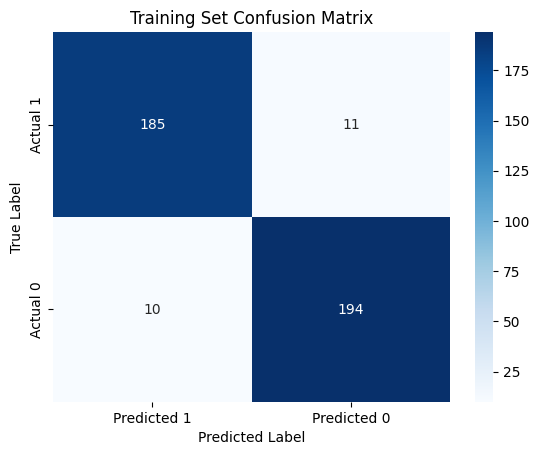

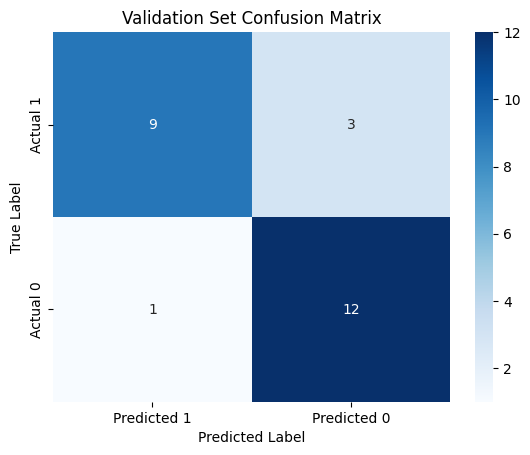

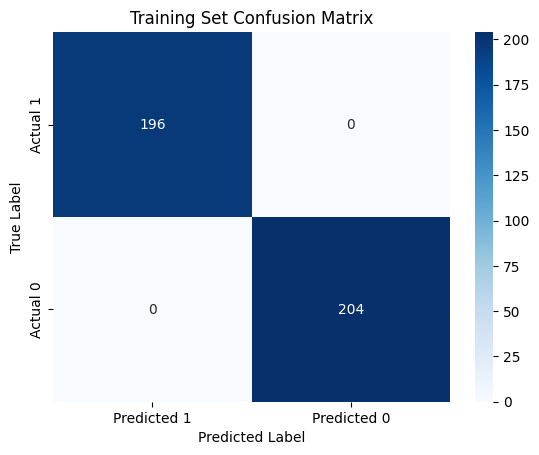

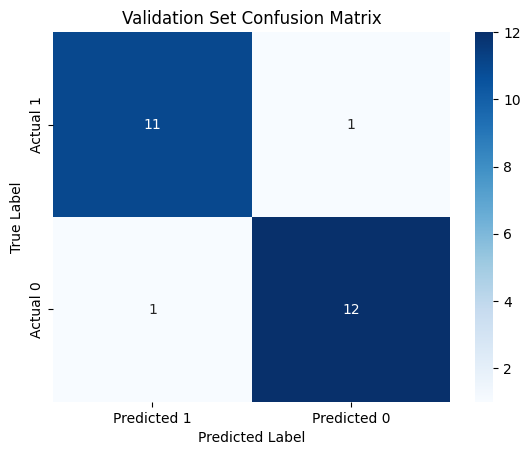

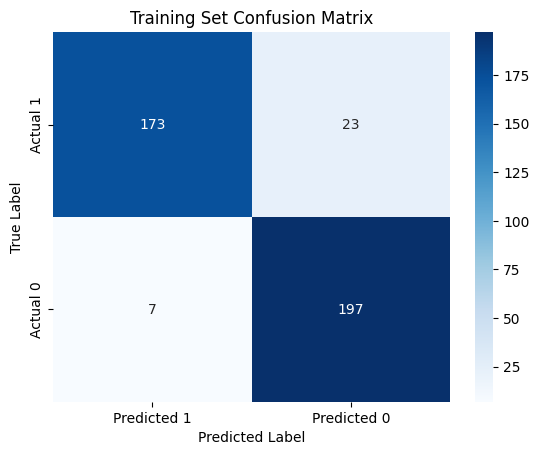

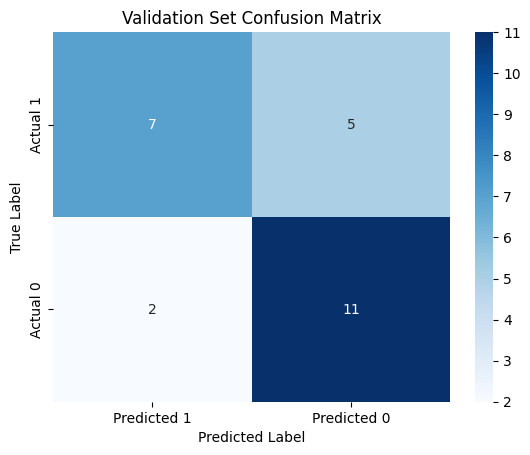

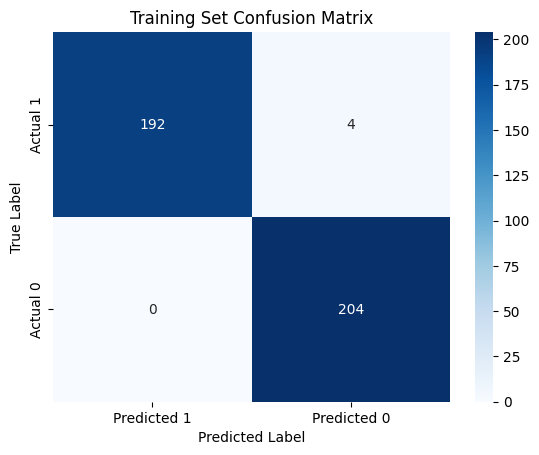

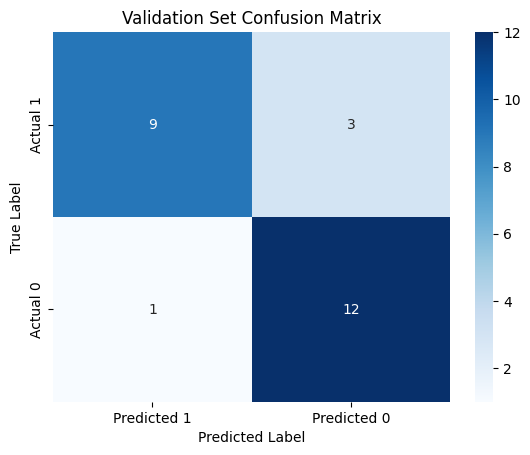

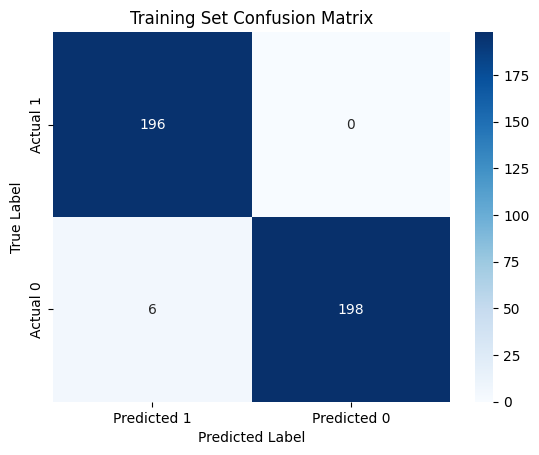

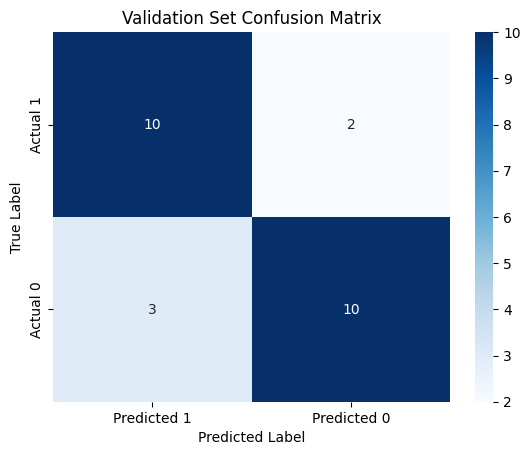

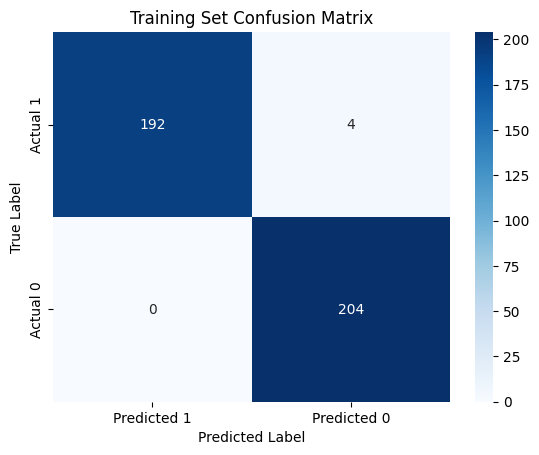

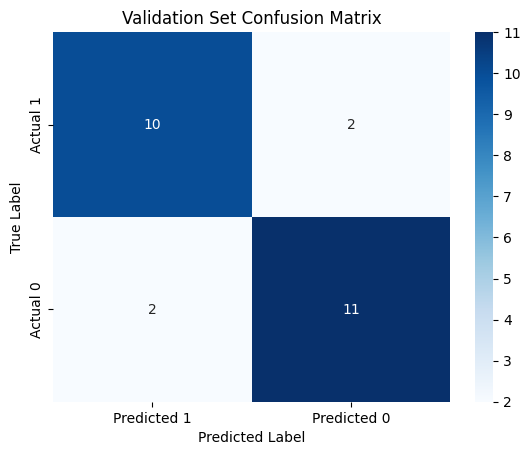

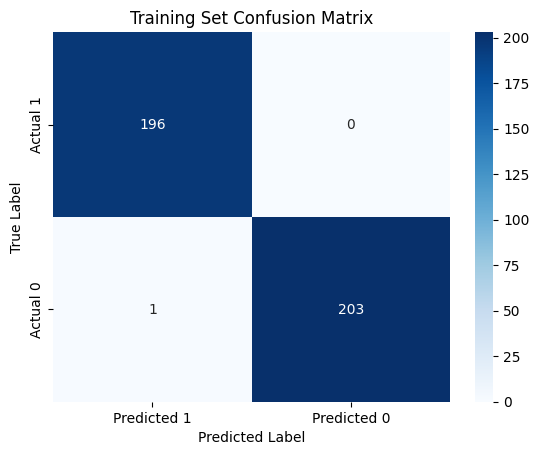

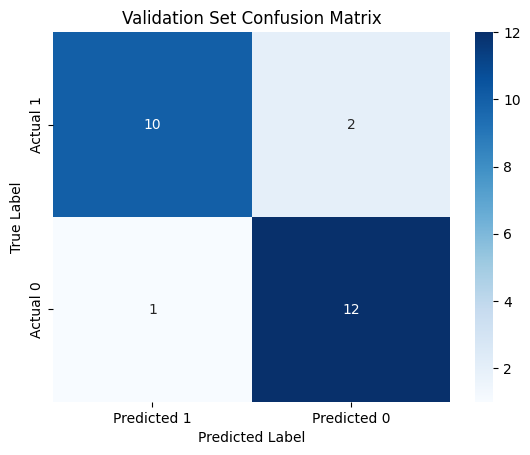

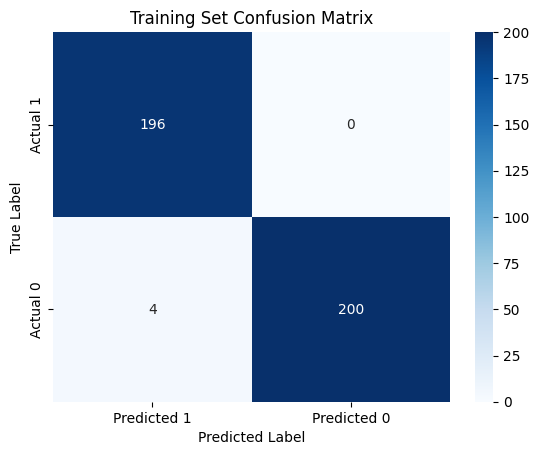

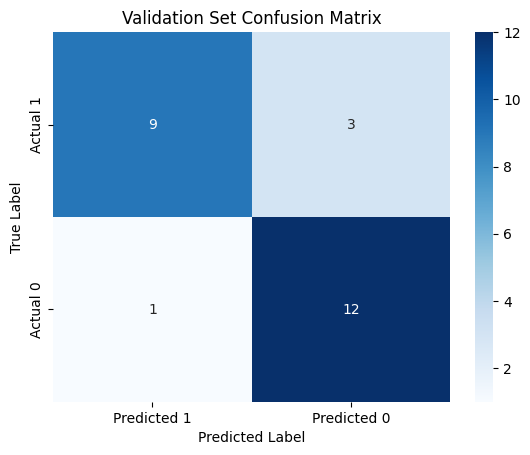

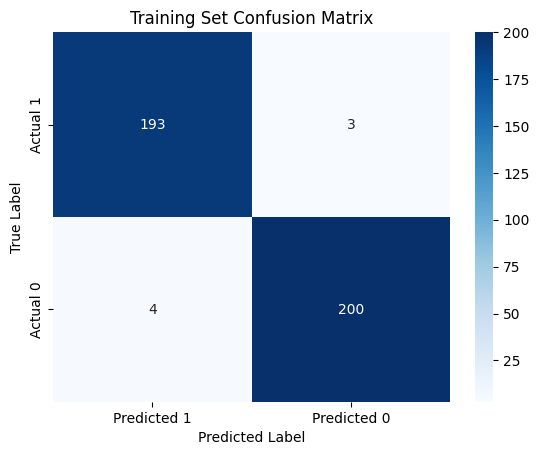

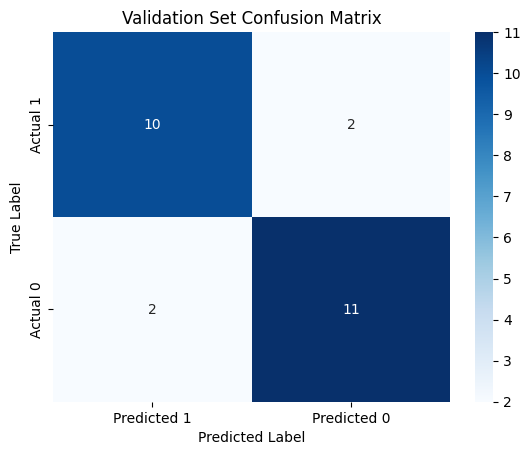

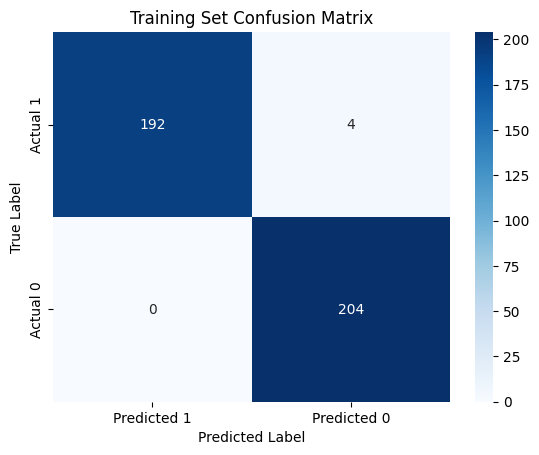

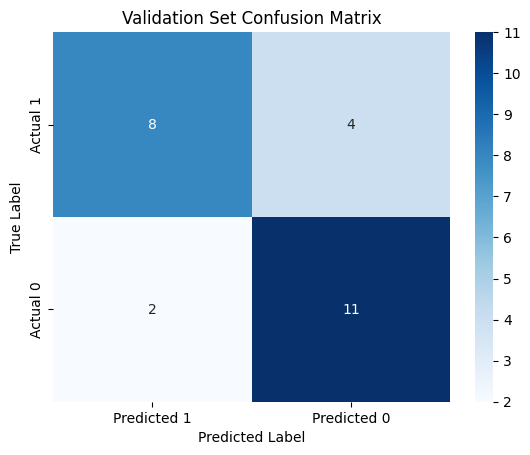

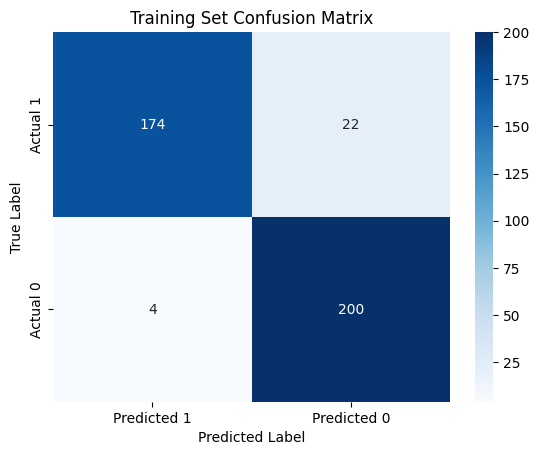

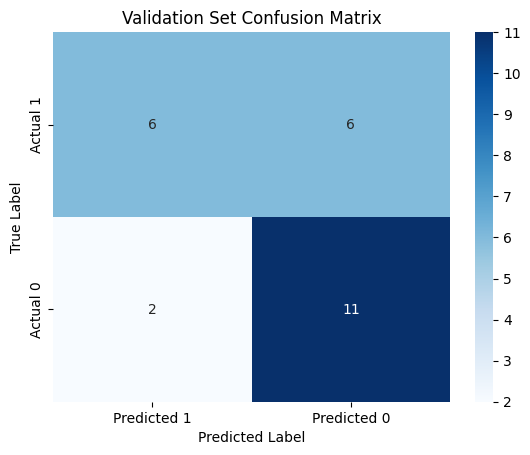

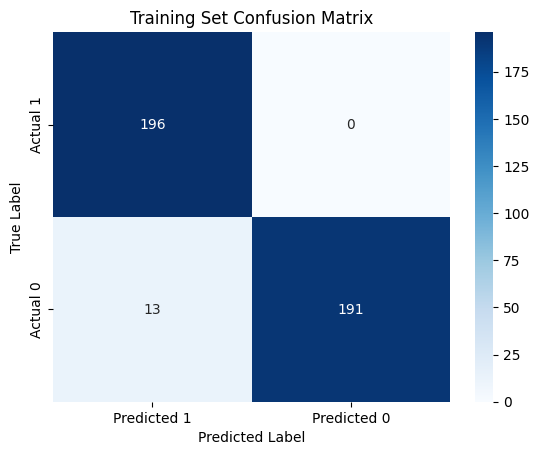

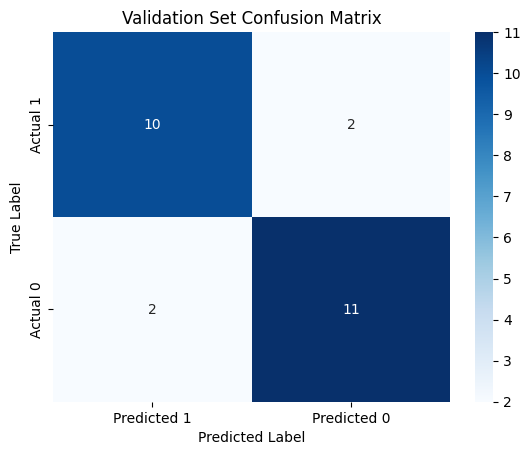

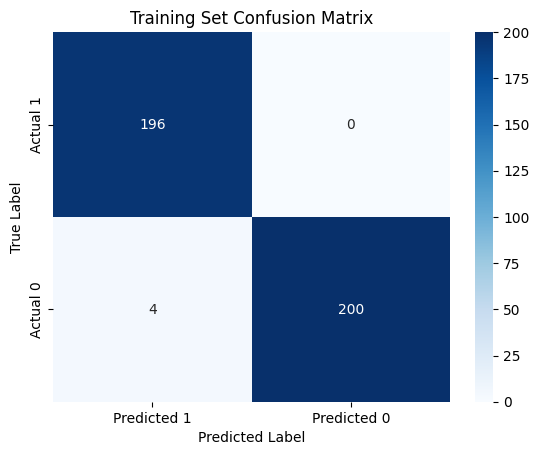

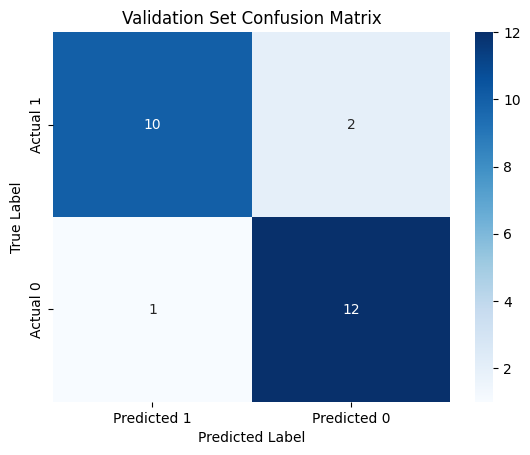

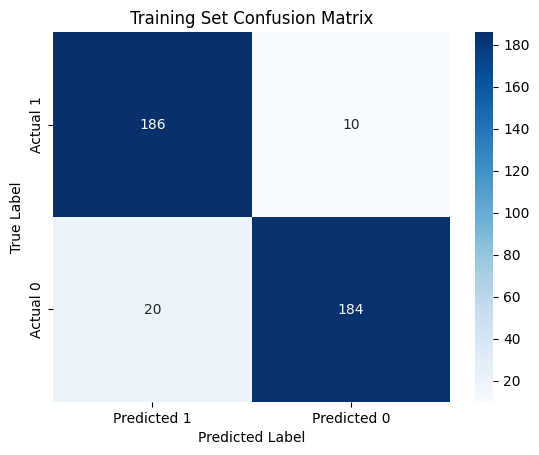

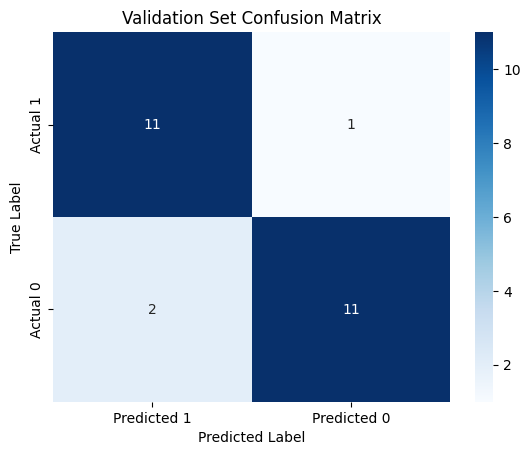

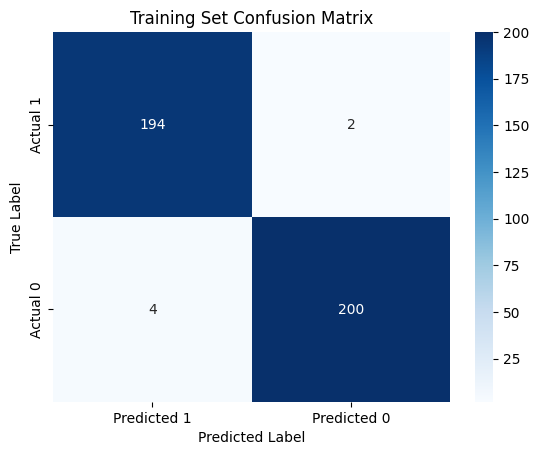

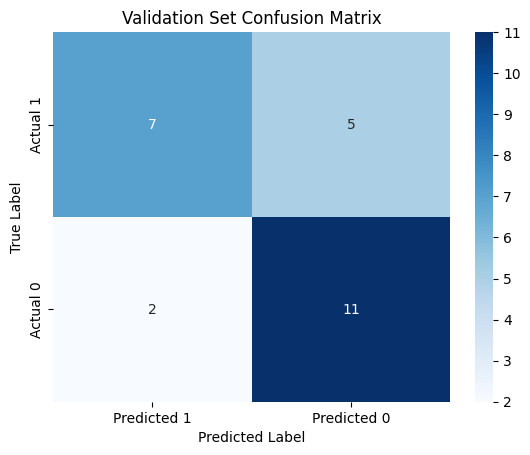

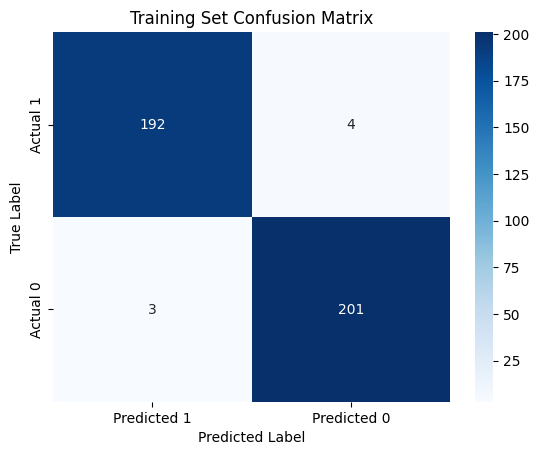

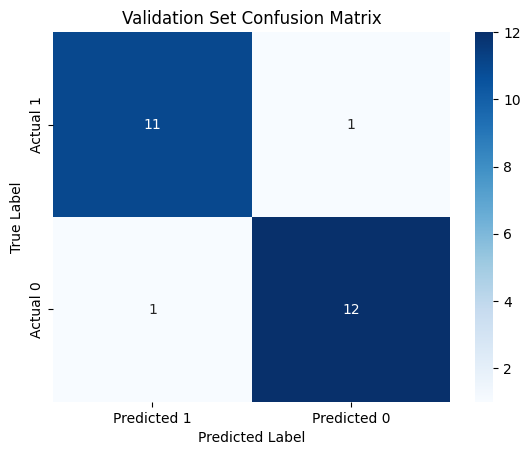

In [22]:
train_num = len(train_paths)
val_num = len(test_paths)

for i in range(16):
    TP = train_true_positives[i]
    FP = train_false_positives[i]
    FN = train_false_negatives[i]
    TN = train_num - (TP + FP + FN)
        
    
    conf_matrix = np.array([[TP, FN], [FP, TN]])

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Training Set Confusion Matrix')
    plt.show()
    
    
    TP = val_true_positives[i]
    FP = val_false_positives[i]
    FN = val_false_negatives[i]
    TN = val_num - (TP + FP + FN)
    
    
    conf_matrix = np.array([[TP, FN], [FP, TN]])

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Validation Set Confusion Matrix')
    plt.show()

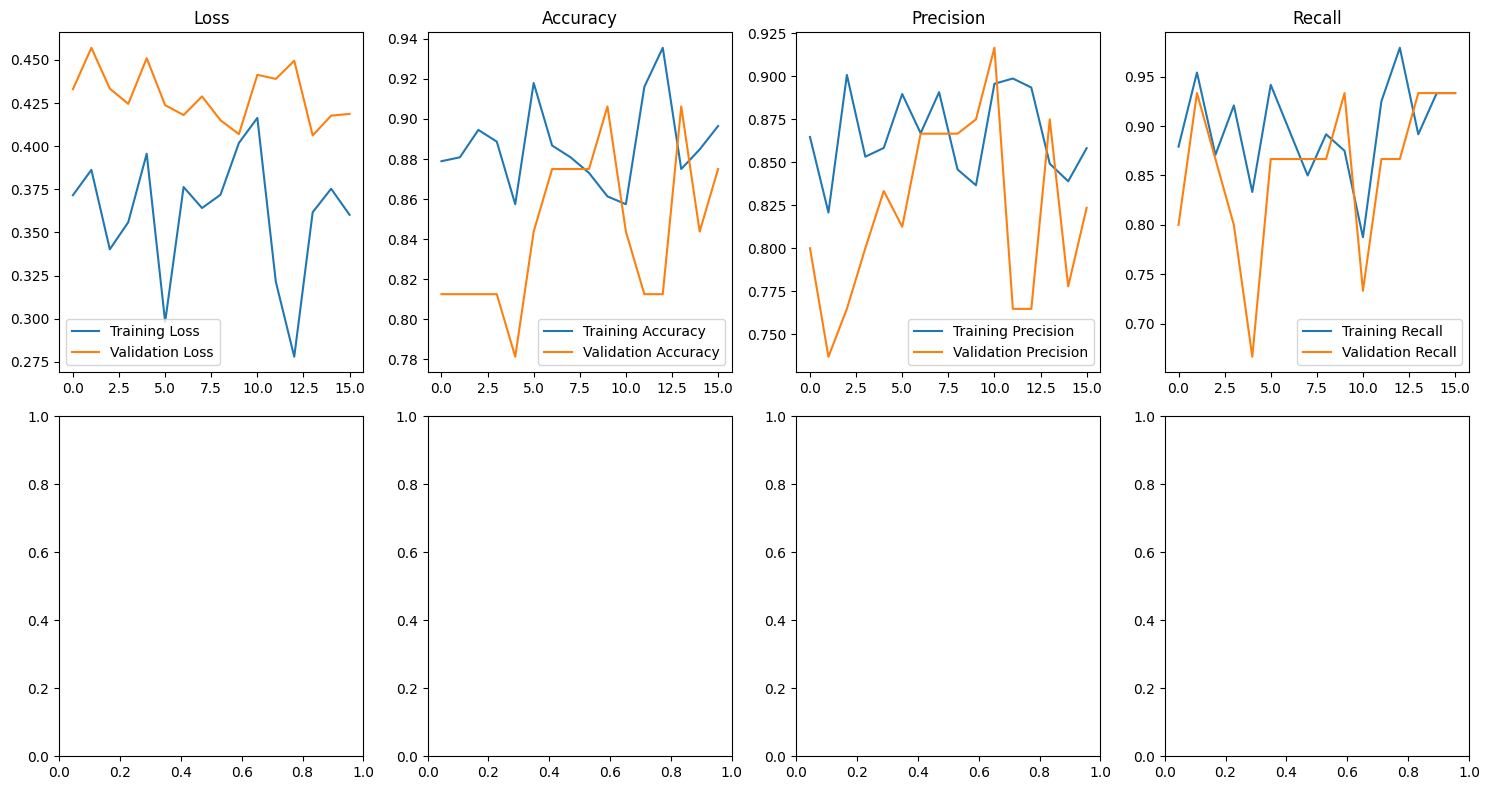

In [25]:
train_losses = [metric[0] for metric in all_train_metrics]
val_losses = [metric[0] for metric in all_val_metrics]
train_accuracies = [metric[1] for metric in all_train_metrics]
val_accuracies = [metric[1] for metric in all_val_metrics]
train_precisions = [metric[2] for metric in all_train_metrics]
val_precisions = [metric[2] for metric in all_val_metrics]
train_recalls = [metric[3] for metric in all_train_metrics]
val_recalls = [metric[3] for metric in all_val_metrics]


train_num = len(train_loader)
val_num = len(valid_loader)
# Plotting code
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# Loss Plots
axs[0, 0].plot(train_losses, label='Training Loss')
axs[0, 0].plot(val_losses, label='Validation Loss')
axs[0, 0].set_title('Loss')
axs[0, 0].legend()

# Accuracy Plots
axs[0, 1].plot(train_accuracies, label='Training Accuracy')
axs[0, 1].plot(val_accuracies, label='Validation Accuracy')
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend()

# Precision Plots
axs[0, 2].plot(train_precisions, label='Training Precision')
axs[0, 2].plot(val_precisions, label='Validation Precision')
axs[0, 2].set_title('Precision')
axs[0, 2].legend()

# Recall Plots
axs[0, 3].plot(train_recalls, label='Training Recall')
axs[0, 3].plot(val_recalls, label='Validation Recall')
axs[0, 3].set_title('Recall')
axs[0, 3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Testing on private dataset

In [67]:
test_paths = glob("C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\final_test_dataset\\left\\" + '*.jpg')

In [68]:
test_dataset = IrisDataset(test_paths)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


all_test_metrics = []

test_true_positives = []
test_false_positives = []
test_false_negatives = []



for i in range(16):
    
    model = build_unet()
    
    model.load_state_dict(torch.load(f"C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\Left Eye Results\\files\\checkpoints\\checkpoint_{i}.pth"))
#     model.load_state_dict(torch.load(f"C:\\Users\\Administrator\\Desktop\\Farid_SDP\\Testing GNN\\SDP\\Iridology_dataset\\Both_Eyes\\files\\checkpoints\\checkpoint_{i}.pth"))

    model = model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    

    test_metric, seperate = evaluate(model, test_loader, loss_fn, device)
    all_test_metrics.append(test_metric)
    
    test_true_positives.append(seperate[0])
    test_false_positives.append(seperate[1])
    test_false_negatives.append(seperate[2])

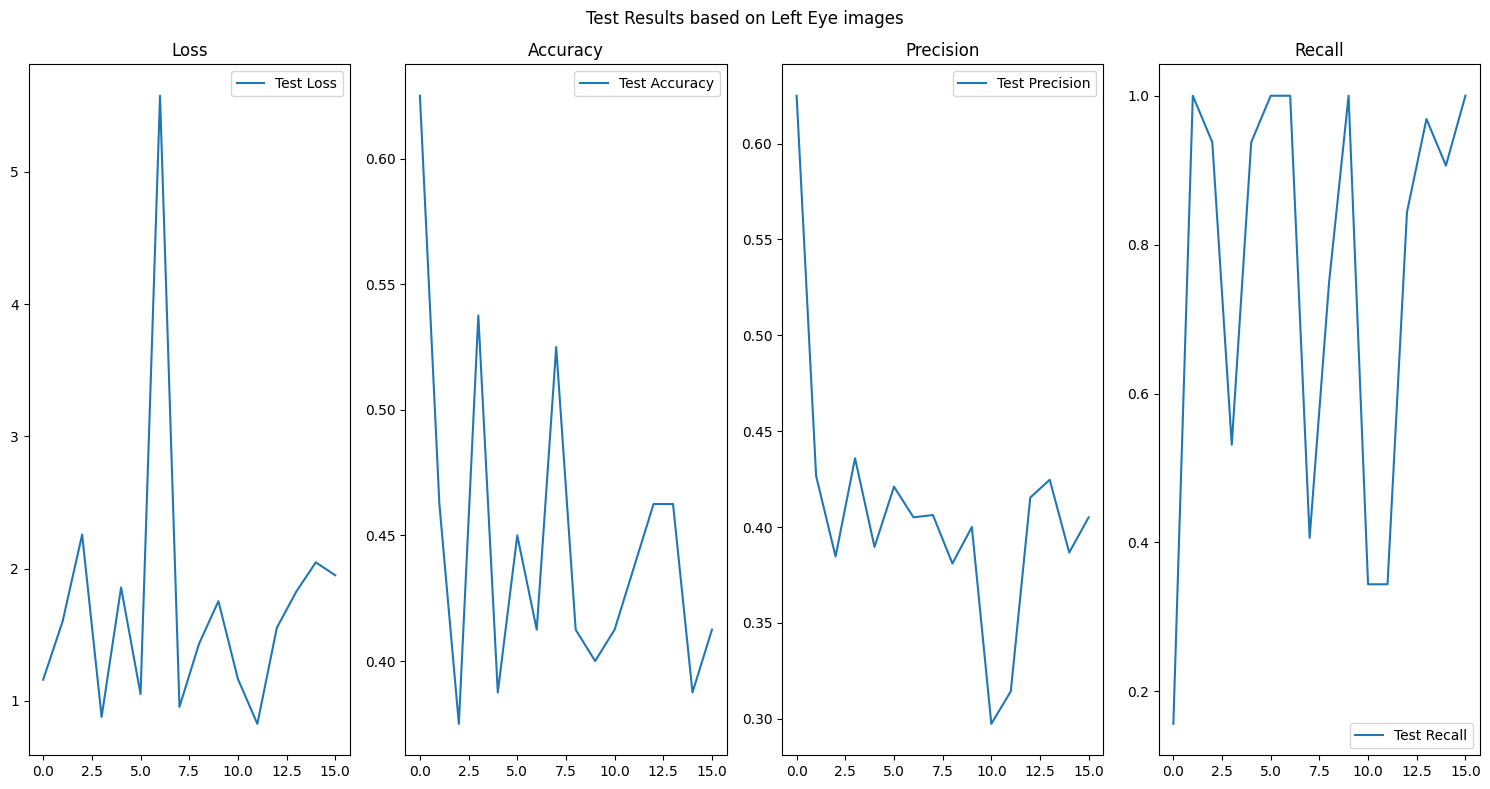

In [69]:
test_losses = [metric[0] for metric in all_test_metrics]
test_accuracies = [metric[1] for metric in all_test_metrics]
test_precisions = [metric[2] for metric in all_test_metrics]
test_recalls = [metric[3] for metric in all_test_metrics]


test_num = len(test_loader)
# Plotting code
fig, axs = plt.subplots(1, 4, figsize=(15, 8))

# Loss Plots
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_title('Loss')
axs[0].legend()

# Accuracy Plots
axs[1].plot(test_accuracies, label='Test Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

# Precision Plots
axs[2].plot(test_precisions, label='Test Precision')
axs[2].set_title('Precision')
axs[2].legend()

# Recall Plots
axs[3].plot(test_recalls, label='Test Recall')
axs[3].set_title('Recall')
axs[3].legend()

plt.suptitle("Test Results based on Left Eye images")
# Adjust layout
plt.tight_layout()
plt.show()

# Model Results Vis

In [36]:
train_file_base = "Iridology_dataset\\Left Eye Results\\train\\"
test_file_base = "Iridology_dataset\\Left Eye Results\\test\\"

train_paths = glob(train_file_base + '*.jpg')
test_paths = glob(test_file_base + '*.jpg')


train_dataset = IrisDataset(train_paths)
valid_dataset = IrisDataset(test_paths)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [140]:
train_file_base = "Iridology_dataset\\Both_Eyes_Total\\train\\"
test_file_base = "Iridology_dataset\\Both_Eyes_Total\\test\\"

train_all_paths = glob(train_file_base + '*.jpg')
test_all_paths = glob(test_file_base + '*.jpg')


train_paths = []
test_paths = []


for i in range(len(train_all_paths)//2):
    
    search_identifier = f"train_{i}_"
    
    both_eyes = [None,None]
    for path in train_all_paths:
        
        left_identifier = search_identifier + "left"
        right_identifier = search_identifier + "right"
        
        if left_identifier  in path:
            both_eyes[1] = path
        elif right_identifier in path:
            both_eyes[0] = path
            
    
    train_paths.append(both_eyes)
    
    

for i in range(1,89):
    
    search_identifier = f"test_{i}_"
    
    both_eyes = [None,None]
    for path in test_all_paths:
        
        left_identifier = search_identifier + "left"
        right_identifier = search_identifier + "right"
        
        if left_identifier  in path:
            both_eyes[1] = path
        elif right_identifier in path:
            both_eyes[0] = path
            
    if both_eyes[0] != None and both_eyes[1] != None:
        test_paths.append(both_eyes)
        
        
train_dataset = IrisDataset(train_paths)
valid_dataset = IrisDataset(test_paths)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
all_train_metrics = []
all_val_metrics = []

train_true_positives = []
train_false_positives = []
train_false_negatives = []

val_true_positives = []
val_false_positives = []
val_false_negatives = []

for i in range(16):
    
#     model = simpleModel()
    model = build_unet()
    model.load_state_dict(torch.load(f"Iridology_dataset/Right Eye Results/files/checkpoints/checkpoint_{i}.pth"))
    model = model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()

    train_metric, seperate = evaluate(model, train_loader, loss_fn, device)
    all_train_metrics.append(train_metric)
    train_true_positives.append(seperate[0])
    train_false_positives.append(seperate[1])
    train_false_negatives.append(seperate[2])

    val_metric, seperate = evaluate(model, valid_loader, loss_fn, device)
    all_val_metrics.append(val_metric)
    
    val_true_positives.append(seperate[0])
    val_false_positives.append(seperate[1])
    val_false_negatives.append(seperate[2])

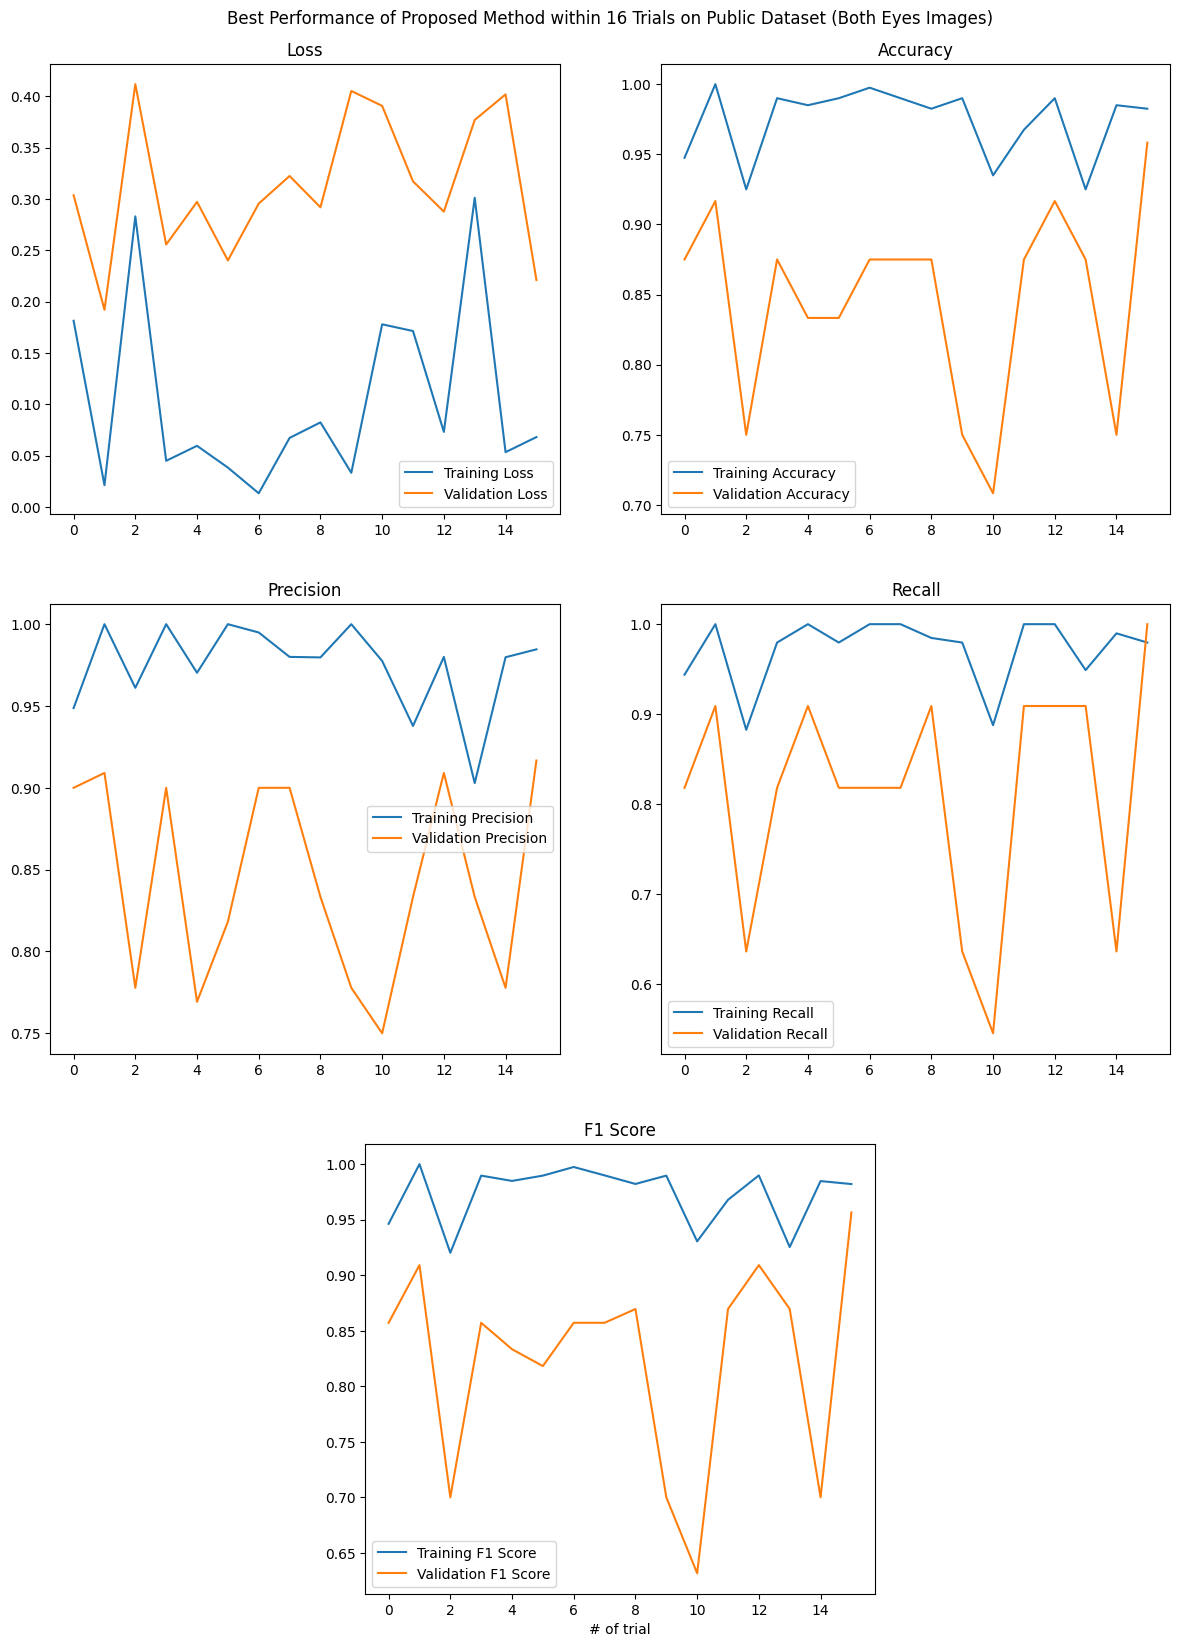

In [73]:
train_losses = [metric[0] for metric in all_train_metrics]
val_losses = [metric[0] for metric in all_val_metrics]
train_accuracies = [metric[1] for metric in all_train_metrics]
val_accuracies = [metric[1] for metric in all_val_metrics]
train_precisions = [metric[2] for metric in all_train_metrics]
val_precisions = [metric[2] for metric in all_val_metrics]
train_recalls = [metric[3] for metric in all_train_metrics]
val_recalls = [metric[3] for metric in all_val_metrics]
train_f1 = [(2*train_precisions[i]*train_recalls[i])/(train_precisions[i]+train_recalls[i]) for i in range(len(train_precisions))]
val_f1 = [(2*val_precisions[i]*val_recalls[i])/(val_precisions[i]+val_recalls[i]) for i in range(len(val_precisions))]

train_num = len(train_loader)
val_num = len(valid_loader)
# Plotting code
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Loss Plots
axs[0][0].plot(train_losses, label='Training Loss')
axs[0][0].plot(val_losses, label='Validation Loss')
axs[0][0].set_title('Loss')
axs[0][0].legend()

# Accuracy Plots
axs[0][1].plot(train_accuracies, label='Training Accuracy')
axs[0][1].plot(val_accuracies, label='Validation Accuracy')
axs[0][1].set_title('Accuracy')
axs[0][1].legend()

# Precision Plots
axs[1][0].plot(train_precisions, label='Training Precision')
axs[1][0].plot(val_precisions, label='Validation Precision')
axs[1][0].set_title('Precision')
axs[1][0].legend()

# Recall Plots
axs[1][1].plot(train_recalls, label='Training Recall')
axs[1][1].plot(val_recalls, label='Validation Recall')
axs[1][1].set_title('Recall')
axs[1][1].legend()

# F1 Score Plots
axs[2][0].plot(train_f1, label='Training F1 Score')
axs[2][0].plot(val_f1, label='Validation F1 Score')
axs[2][0].set_title('F1 Score')
axs[2][0].legend()
axs[2][0].set_xlabel("# of trial")
# Hide axs[2][1]
axs[2][1].set_visible(False)

plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.2, wspace=0.2)

pos = axs[2][0].get_position()
pos.x0 += 0.225  # Adjust left position
pos.x1 += 0.225  # Adjust right position
axs[2][0].set_position(pos)
# Adjust layout

# fig.text(0.48, 0.001, '# of Model', ha='center',fontsize=14)
plt.suptitle("Best Performance of Proposed Method within 16 Trials on Public Dataset (Both Eyes Images)")

plt.show()

In [26]:
print("Training Accuracy Mean: ",np.mean(train_accuracies))
print("Training Accuracy STD: ",np.std(train_accuracies))
print("Val Accuracy Mean: ",np.mean(val_accuracies))
print("Val Accuracy STD: ",np.std(val_accuracies))
print("\n"),

print("Training Precision Mean: ",np.mean(train_precisions))
print("Training Precision STD: ",np.std(train_precisions))
print("Val Precision Mean: ",np.mean(val_precisions))
print("Val Precision STD: ",np.std(val_precisions))
print("\n")

print("Training Recall Mean: ",np.mean(train_recalls))
print("Training Recall STD: ",np.std(train_recalls))
print("Val Recall Mean: ",np.mean(val_recalls))
print("Val Recall STD: ",np.std(val_recalls))
print("\n")

print("Training F1 Mean: ",np.mean(train_f1))
print("Training F1 STD: ",np.std(train_f1))
print("Val F1 Mean: ",np.mean(val_f1))
print("Val F1 STD: ",np.std(val_f1))

Training Accuracy Mean:  0.8253968253968254
Training Accuracy STD:  0.0
Val Accuracy Mean:  0.6666666666666666
Val Accuracy STD:  0.0


Training Precision Mean:  0.8058823529409395
Training Precision STD:  0.0
Val Precision Mean:  0.631578947365097
Val Precision STD:  0.0


Training Recall Mean:  0.8058823529409395
Training Recall STD:  0.0
Val Recall Mean:  0.5714285714258504
Val Recall STD:  0.0


Training F1 Mean:  0.8058823529409395
Training F1 STD:  0.0
Val F1 Mean:  0.599999999997
Val F1 STD:  0.0


## Validation Time Statistics

In [149]:
def predict_image(image_tensor,model_path):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = build_unet()
    model = simpleModel()
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = torch.sigmoid(model(image_tensor))

        prediction = torch.round(output)
    
    return prediction

In [150]:
train_file_base = "Iridology_dataset\\Left Eye Total Results\\train\\"
test_file_base = "Iridology_dataset\\Left Eye Total Results\\test\\"

train_paths = glob(train_file_base + '*.jpg')
test_paths = glob(test_file_base + '*.jpg')


train_dataset = IrisDataset(train_paths)
valid_dataset = IrisDataset(test_paths)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = f"Iridology_dataset/Both_Eyes_Total/files_cnn_both/checkpoints/checkpoint_0.pth"

In [ ]:
prediction_times = []


for x, y in valid_loader:
    start_time = time.time()
    predict_image(x,model_path)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    prediction_times.append(elapsed_time)

In [95]:
print("MIN validation time: ", np.min(prediction_times))
print("MAX validation time: ", np.max(prediction_times))
print("MEAN validation time: ", np.mean(prediction_times))

MIN validation time:  0.16000080108642578
MAX validation time:  0.4680032730102539
MEAN validation time:  0.17663922905921936


# Visualizing Predictions

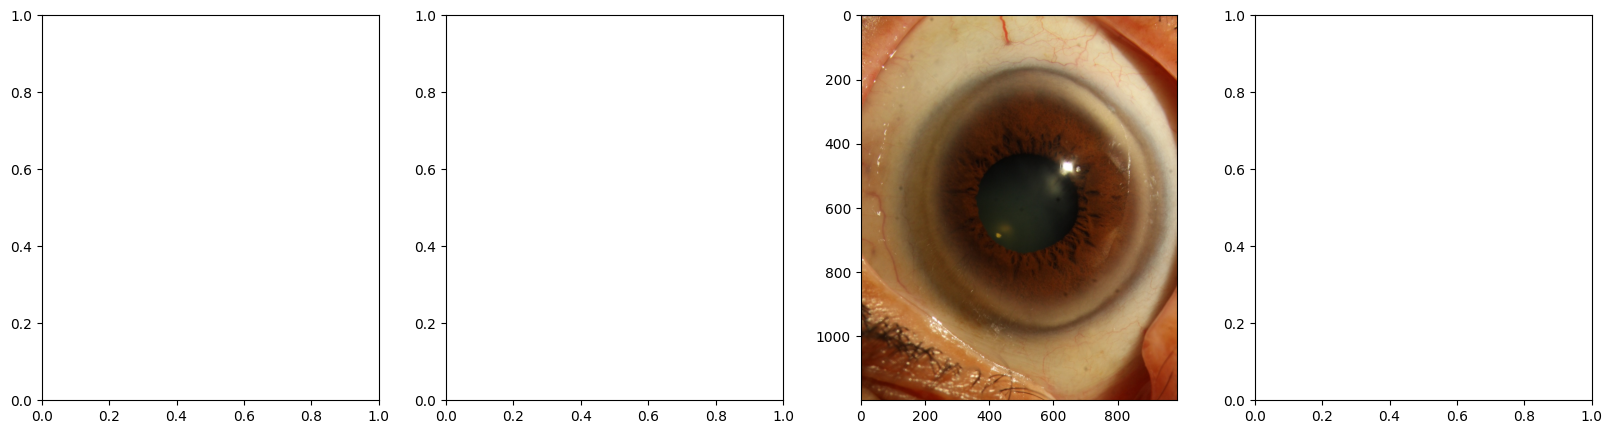

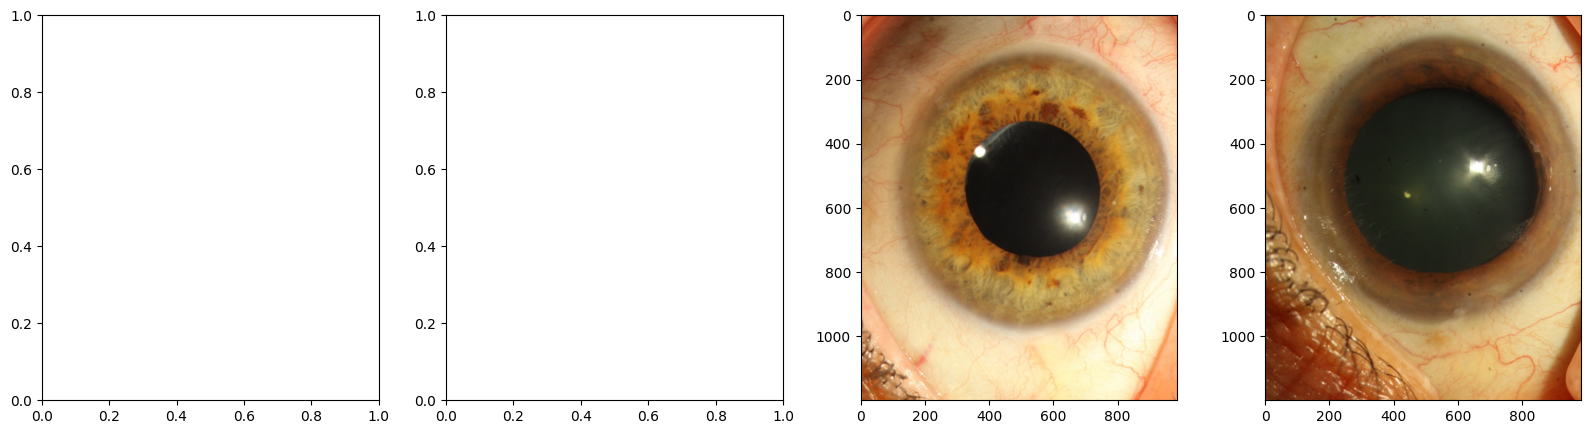

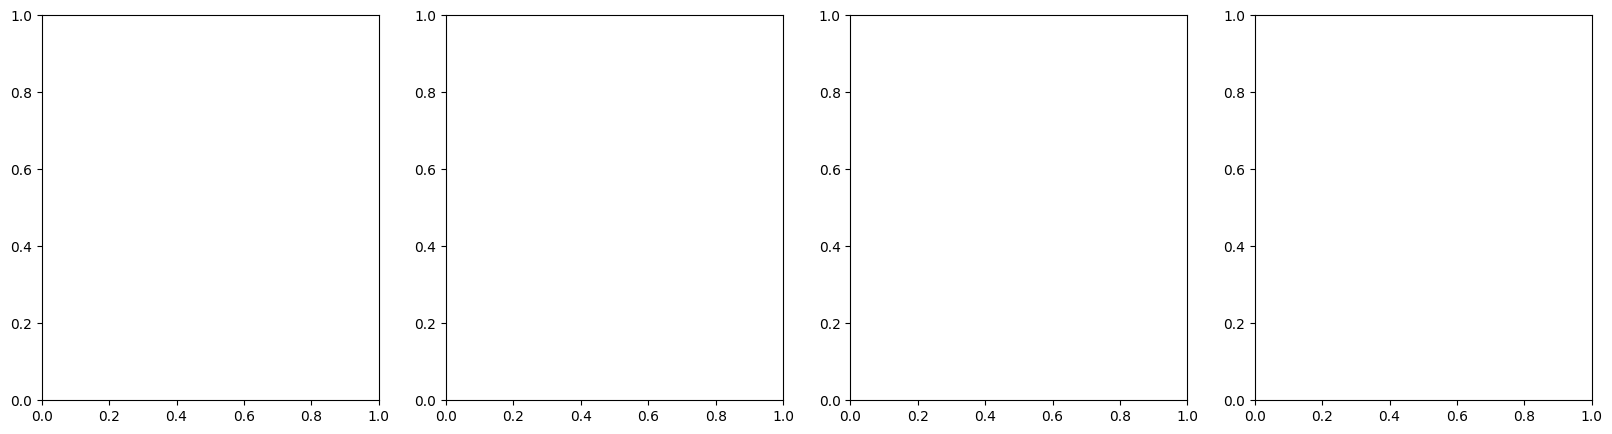

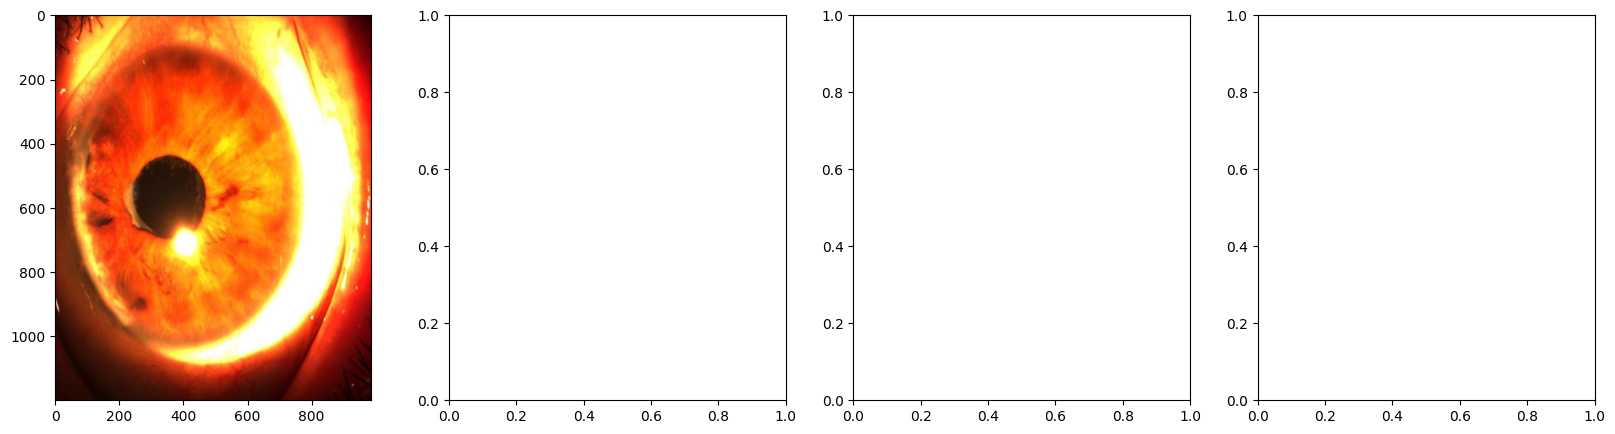

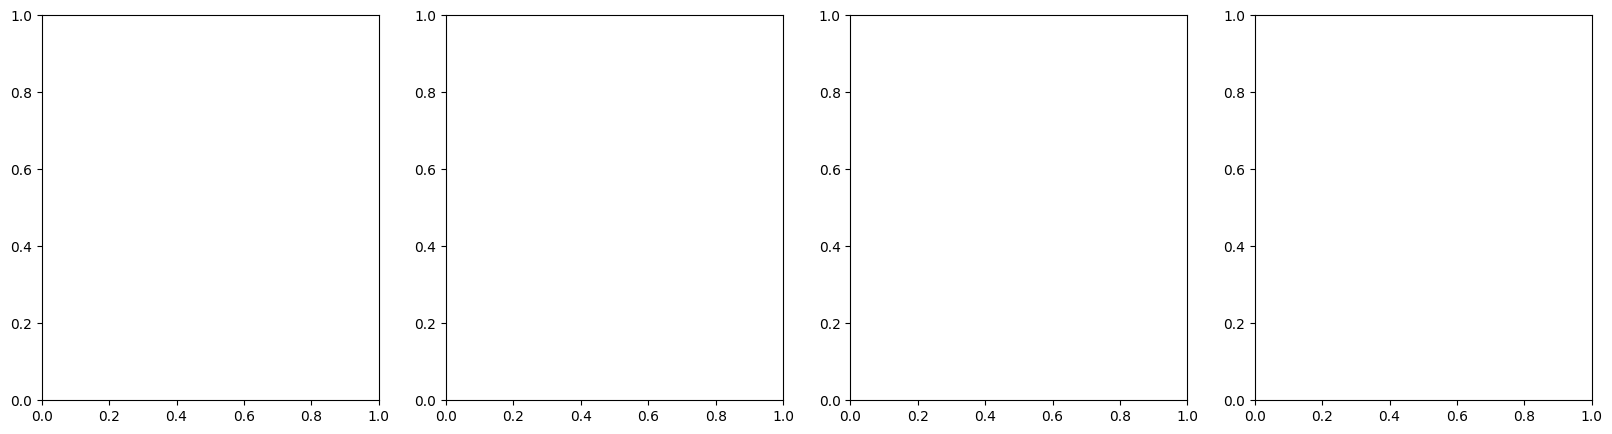

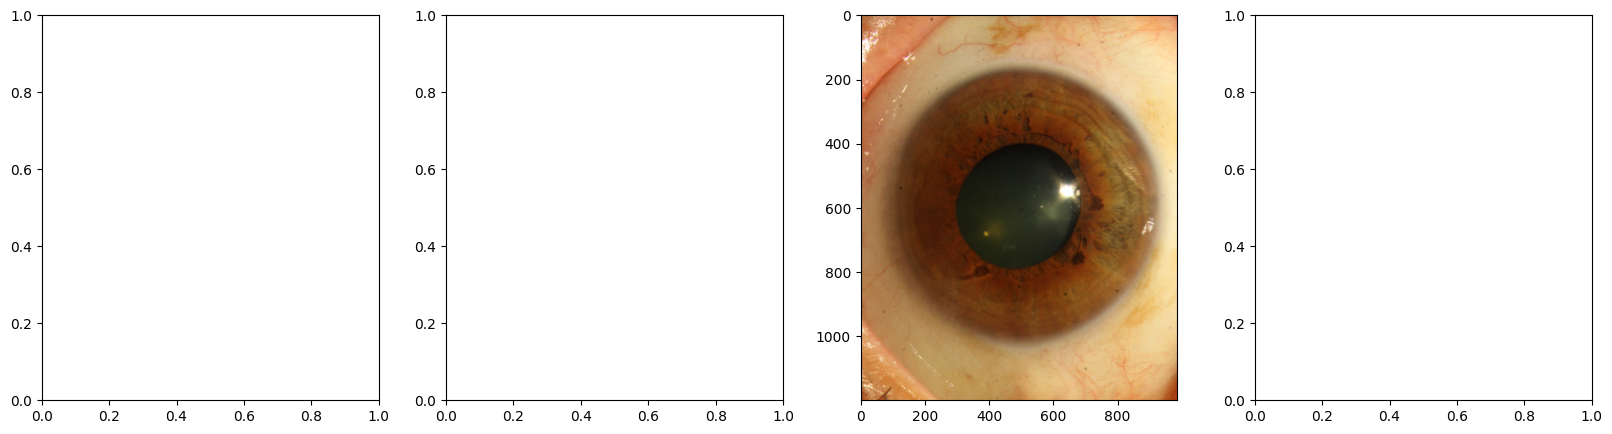

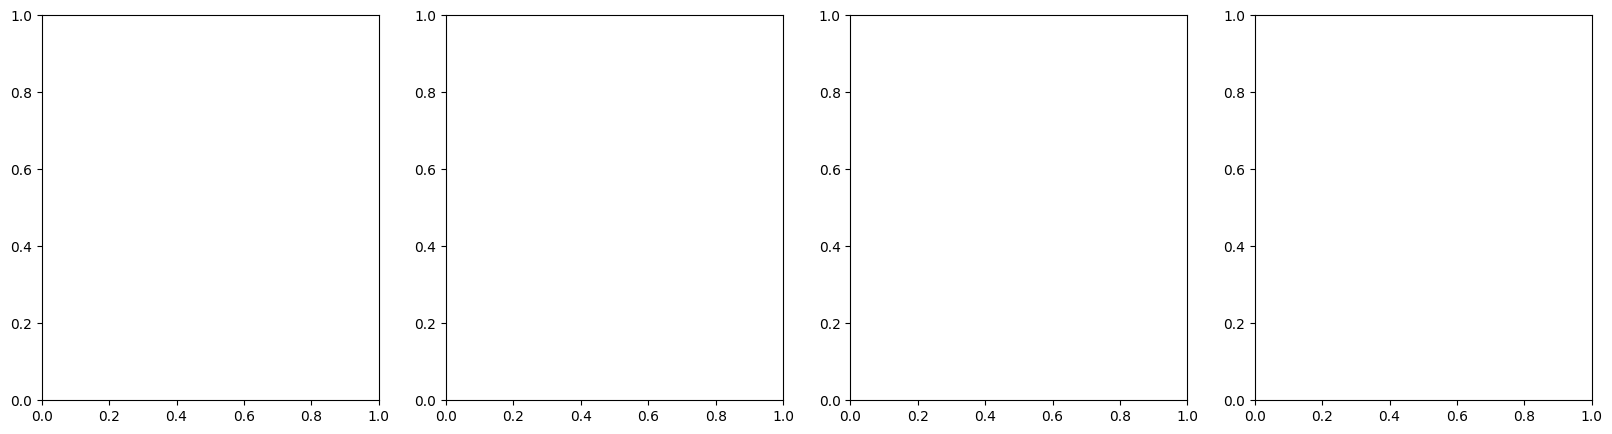

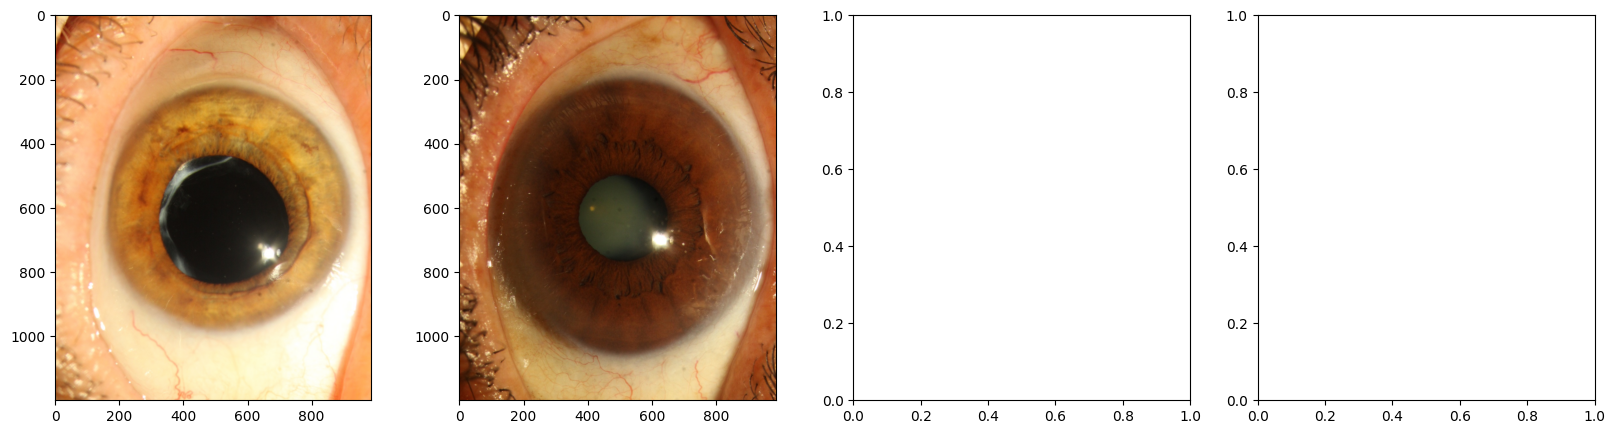

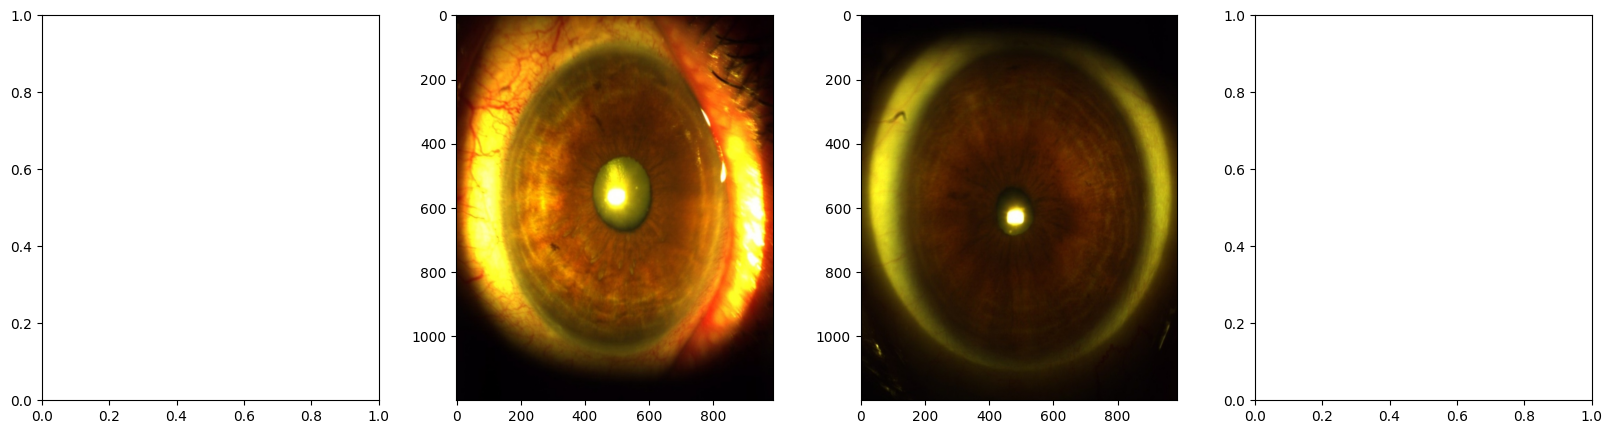

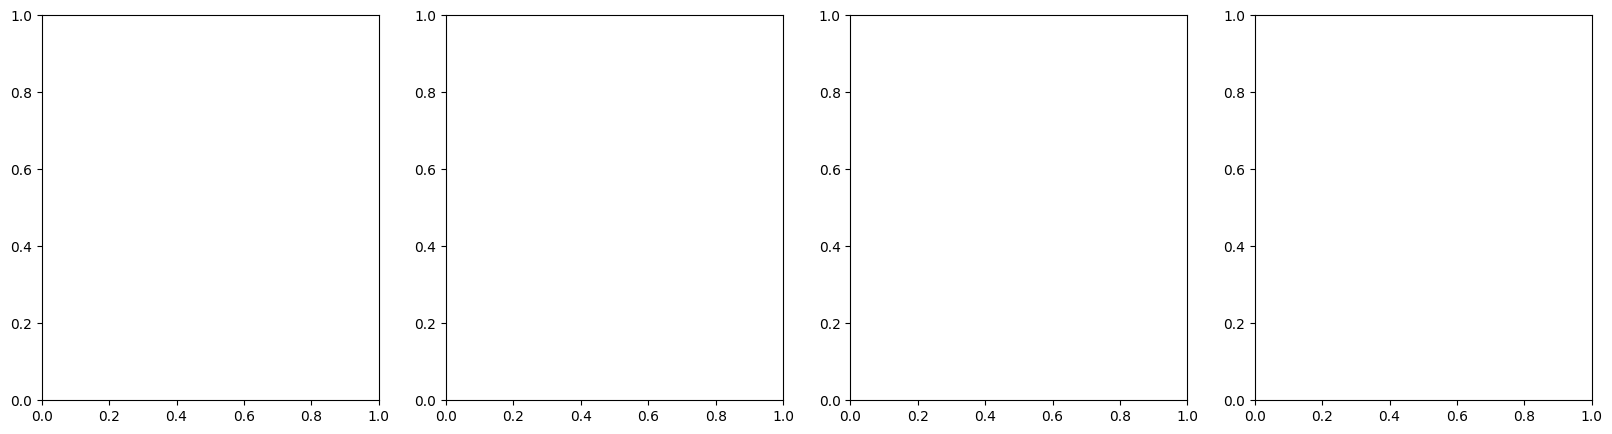

40


In [151]:
prediction_times = []

cnt = 0

for x, y in valid_loader:
    start_time = time.time()
    predictions = predict_image(x,model_path)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    prediction_times.append(elapsed_time)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    for indx, img in enumerate(x):
        
        if y[indx] != predictions[indx]:
            
            plot_img = np.transpose(img[:3,:,:], (2, 1, 0)).numpy()
            plot_img = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
            axs[indx].imshow(plot_img)
            
        cnt += 1
            
    plt.show()
    
print(cnt)